### "Шапка" с названием проекта

В этой ячейке вы найдете оглавление и ключевые этапы работы, которые помогут вам ориентироваться в процессе выполнения проекта. Проект разделен на пять основных этапов, четыре из которых (этапы 2, 3, 4 и 5) вам предлагается выполнить в этом Jupyter Notebook:

- Подготовка среды MLflow - Первый шаг, подготовка и запуск сервисов MLflow, был выполнен вне ноутбука и оформлен в виде shell скрипта. Это основа для работы с экспериментами и логирования результатов ваших моделей.

- Этап 2 - Исследовательский Анализ Данных (EDA): На этом этапе вы проведете тщательный анализ данных, чтобы лучше понять их структуру и особенности.

- Этап 3 - Генерация Признаков и Обучение Модели: После анализа данных вы сгенерируете новые признаки и обучите модель, используя эти признаки.

- Этап 4 - Отбор Признаков и Обучение Модели: На этом шаге вы отберете наиболее значимые признаки и снова обучите модель для улучшения ее качества.

- Этап 5 - Подбор Гиперпараметров и Обучение Финальной Версии Модели: Финальный этап проекта посвящен оптимизации гиперпараметров для достижения максимального качества модели.

Для удобства навигации и организации работы, пожалуйста, следуйте оглавлению и рекомендациям, описанным в каждом этапе.

> ### Важно: Переобучение моделей
> На каждом этапе проекта, где требуется переобучение модели, важно не просто выполнить эту процедуру, но и тщательно проверить качество модели на соответствующих выборках. Это включает в себя анализ метрик качества, визуализацию результатов, сравнение с предыдущими моделями и, при необходимости, корректировку.

> ### Важно: Разделение выборок
> Перед началом выполнения вашего проекта важно правильно подготовить данные, разделив их на подвыборки. Это позволит оценить производительность модели более объективно и управлять риском переобучения. В зависимости от ваших целей и доступных данных, вы можете использовать различные стратегии разделения:

1. Разделение на train/val/test: Это классический подход, где данные делятся на три части. Обучающая выборка (train) используется для первичного обучения моделей, валидационная (val) - для настройки гиперпараметров и выбора лучшей модели, а тестовая (test) - для финальной оценки производительности модели. Такой подход идеален, если у вас достаточно данных, чтобы разделить их и каждая из выборок была репрезентативна.

2. Разделение на train/test с кросс-валидацией на train: Если данных недостаточно для трех подвыборок, можно ограничиться разделением на обучающую и тестовую выборки. В этом случае кросс-валидация на обучающей выборке поможет оценить стабильность модели и подобрать гиперпараметры.

Определение способа разделения данных: Выбор метода разбиения данных на подвыборки — train, validation и test — должен быть обоснован особенностями вашего набора данных и задачами проекта. Возможные методы разделения, включая различные стратегии и правила, подробно описаны в [документации scikit-learn по разбиению данных](https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py). Вы можете следовать этим примерам или разработать собственный метод, исходя из специфики ваших данных.

Ваша задача - выбрать подходящий метод разделения данных исходя из объема и специфики ваших данных. Помните, что финальные метрики качества модели мы будем оценивать на тестовой выборке. Промежуточные результаты после каждого этапа проекта (например, после настройки гиперпараметров) следует оценивать на валидационной выборке, если таковая имеется. Это поможет вам корректно настроить модель перед финальной оценкой её производительности.

In [ ]:
# libs

import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from category_encoders import CatBoostEncoder
from sklearn.preprocessing import (
    OneHotEncoder,
    TargetEncoder,
    StandardScaler,
    SplineTransformer,
    QuantileTransformer, 
    RobustScaler,
    PolynomialFeatures,
    KBinsDiscretizer,
)
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    mean_absolute_percentage_error
)
from catboost import CatBoostRegressor
from autofeat import AutoFeatRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

import optuna
from optuna.samplers import CmaEsSampler
from optuna.integration.mlflow import MLflowCallback


In [2]:
# константы для логирования в mlflow

EXPERIMENT_NAME = "real_estate_model_alexdem"


os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net"
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID")
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

In [3]:
# 2.1 Загрузка данных

# функция для создания соединения с базой данных

def create_connection():

    load_dotenv()
    host = os.environ.get('DB_DESTINATION_HOST')
    port = os.environ.get('DB_DESTINATION_PORT')
    db = os.environ.get('DB_DESTINATION_NAME')
    username = os.environ.get('DB_DESTINATION_USER')
    password = os.environ.get('DB_DESTINATION_PASSWORD')
    
    conn = create_engine(f'postgresql://{username}:{password}@{host}:{port}/{db}', connect_args={'sslmode':'require'})
    return conn

conn = create_connection()
data = pd.read_sql('select * from buildings_clean', conn, index_col='id')
data.drop(columns='building_id', inplace=True)
conn.dispose()

In [4]:
# сделайте разделение изначального набора данных в этой ячейке

target_col = 'price'
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=target_col), data[target_col], test_size=0.2, random_state=42)

In [5]:
X_train.head()

,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,is_apartment,kitchen_area,living_area,rooms,studio,total_area
id,,,,,,,,,,,,,,,
593,2013,4,55.623081,37.312424,2.74,192,17,True,9,False,12.00,33.0,2,False,59.400002
7555,1971,6,55.677773,37.680195,2.64,84,12,True,10,False,10.00,20.0,1,False,35.000000
2685,2004,4,55.759678,37.713486,2.74,239,15,True,7,False,10.00,26.0,1,False,39.000000
4744,2005,4,55.653324,37.398193,2.74,436,17,True,13,False,10.00,0.0,2,False,52.000000
5169,1967,1,55.848534,37.493271,2.48,119,5,False,1,False,5.77,42.0,3,False,56.669998


#### Этап 2: Исследовательский Анализ Данных (EDA)
На этом этапе ваша задача - провести тщательный исследовательский анализ данных (EDA), чтобы глубже понять особенности и связи в предоставленном наборе данных. В процессе EDA вы должны обратить внимание на три ключевых аспекта, о которых мы говорили в теме 3 курса. Очень важно, чтобы все результаты вашего исследования, включая визуализации, статистический анализ и предварительные выводы, были аккуратно залогированы в MLflow.

Для более организованного исследования предлагаем следующие рекомендуемые шаги:
- Понимание данных: Первоначально ознакомьтесь с данными, изучите типы данных, проверьте наличие пропущенных значений.
- Визуализация данных: Используйте графики и диаграммы для визуализации распределений признаков и возможных взаимосвязей между ними.
- Статистический анализ: Примените статистические методы для изучения центральных тенденций, разброса и корреляций между признаками.
- Предварительные выводы: На основе проведённого анализа сформулируйте предварительные выводы о данных, которые помогут в дальнейшем этапе моделирования.

Помните, что EDA - это итеративный процесс, в котором вы можете возвращаться к предыдущим шагам для дополнительного анализа, если это будет необходимо. Все находки и выводы должны быть чётко зафиксированы и легко доступны для команды проекта.


In [6]:
ASSETS_DIR = "assets"

os.makedirs(ASSETS_DIR, exist_ok=True) # или os.makedirs(ASSETS_DIR, exist_ok=True)

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64

sns.set_style("white")
sns.set_theme(style="whitegrid") 

In [7]:
# 2.2. Общий обзор датасета

In [8]:
print('Первые 5 строк датасета:')
data.head()

Первые 5 строк датасета:


,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,is_apartment,kitchen_area,living_area,rooms,studio,total_area,price
id,,,,,,,,,,,,,,,,
1,1961,1,55.706188,37.740948,2.64,60,5,False,3,False,6.00,30.000000,2,False,41.00,10400000.0
2,1979,4,55.618950,37.540848,2.64,256,16,True,5,False,9.00,34.000000,2,False,54.00,10500000.0
3,1983,4,55.670040,37.742149,2.64,203,17,True,6,False,10.00,31.000000,2,False,56.00,12200000.0
4,1973,4,55.763409,37.825542,2.64,431,9,True,1,False,7.00,29.000000,2,False,45.00,7300000.0
5,1971,4,55.806629,37.806507,2.64,98,14,True,1,False,6.21,23.790001,2,False,38.32,9000000.0


In [9]:
print('Последние 5 строк датасета:')
data.tail()


Последние 5 строк датасета:


,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,is_apartment,kitchen_area,living_area,rooms,studio,total_area,price
id,,,,,,,,,,,,,,,,
22405,1960,0,55.806961,37.723949,3.00,40,5,False,4,False,6.0,34.0,3,False,54.0,8500000.0
22406,1997,4,55.683281,37.576797,2.64,132,17,True,5,False,9.0,14.0,1,False,35.0,10500000.0
22407,1958,1,55.789494,37.635223,3.20,119,10,True,9,False,12.0,59.0,3,False,98.0,20000000.0
22408,2006,1,55.907280,37.567455,3.00,53,6,True,4,False,10.0,33.0,2,False,65.0,16500000.0
22409,1928,1,55.756195,37.656567,2.80,81,7,True,5,False,8.0,46.0,3,False,65.0,20000000.0


In [10]:
print('Описание датасета:')
data.describe()

Описание датасета:


,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,floor,kitchen_area,living_area,rooms,total_area,price
count,22409.000000,22409.000000,22409.000000,22409.000000,22409.000000,22409.000000,22409.000000,22409.000000,22409.000000,22409.000000,22409.000000,22409.000000,2.240900e+04
mean,1980.626177,3.278370,55.739031,37.597691,2.717959,178.232764,12.152037,6.313088,8.301088,29.695944,1.996876,53.679269,1.282186e+07
std,21.181657,1.635053,0.102967,0.147590,0.178834,128.852846,5.634179,4.596798,3.408632,15.488303,0.851207,19.627558,6.366264e+06
min,1902.000000,0.000000,55.309727,36.920021,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,11.000000,8.500000e+01
25%,1965.000000,2.000000,55.664127,37.498959,2.640000,81.000000,8.000000,3.000000,6.000000,19.500000,1.000000,38.500000,8.500000e+06
50%,1976.000000,4.000000,55.740452,37.590607,2.640000,140.000000,12.000000,5.000000,8.500000,29.100000,2.000000,50.000000,1.110000e+07
75%,2000.000000,4.000000,55.815403,37.713711,2.750000,240.000000,16.000000,9.000000,10.000000,39.000000,3.000000,63.799999,1.500000e+07
max,2023.000000,6.000000,56.011032,37.946411,3.600000,726.000000,40.000000,27.000000,22.000000,105.699997,7.000000,162.800003,4.080000e+07


In [11]:
print('Количество пропущенных значений в процентах:')
data.isnull().sum() / len(data)


Количество пропущенных значений в процентах:


build_year           0.0
building_type_int    0.0
latitude             0.0
longitude            0.0
ceiling_height       0.0
flats_count          0.0
floors_total         0.0
has_elevator         0.0
floor                0.0
is_apartment         0.0
kitchen_area         0.0
living_area          0.0
rooms                0.0
studio               0.0
total_area           0.0
price                0.0
dtype: float64

In [12]:
data.shape

(22409, 16)

In [13]:
data.dtypes

build_year             int64
building_type_int      int64
latitude             float64
longitude            float64
ceiling_height       float64
flats_count            int64
floors_total           int64
has_elevator            bool
floor                  int64
is_apartment            bool
kitchen_area         float64
living_area          float64
rooms                  int64
studio                  bool
total_area           float64
price                float64
dtype: object

In [14]:
# 2.3 Анализ признаков для модели

In [15]:
binary_features = list(data.select_dtypes(include=['bool']).columns)

data[binary_features].value_counts(normalize=True)


has_elevator  is_apartment  studio
True          False         False     0.812441
False         False         False     0.181088
True          True          False     0.005712
False         True          False     0.000759
Name: proportion, dtype: float64

In [16]:
categorical_features = ['building_type_int']

data[categorical_features].value_counts(normalize=True)


building_type_int
4                    0.538355
1                    0.221027
6                    0.115311
2                    0.100540
0                    0.021108
3                    0.003659
Name: proportion, dtype: float64

In [17]:
numeric_features = list(data.drop(columns=categorical_features+[target_col]).select_dtypes(include=['int64', 'float64']).columns)


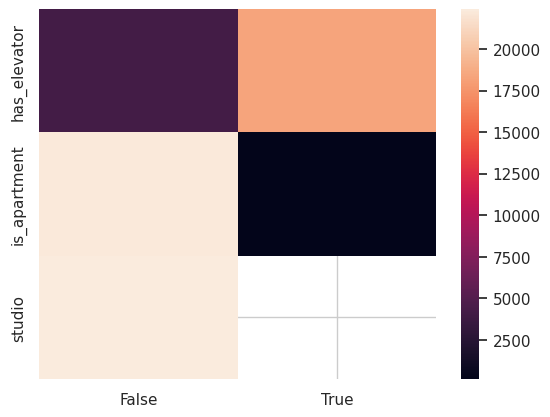

In [18]:
heat_df = data[binary_features].apply(pd.Series.value_counts).T
sns.heatmap(heat_df)

plt.savefig(os.path.join(ASSETS_DIR, 'binary_features_heatmap.png'))
plt.show()


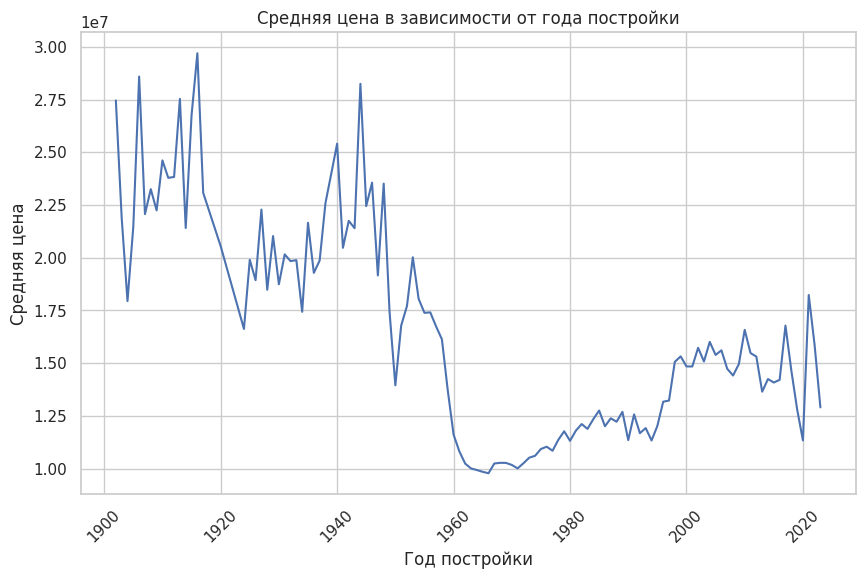

In [19]:


build_year_df = data[['build_year', target_col]].groupby('build_year', as_index=False).mean().sort_values(by='build_year', ascending=False)

plt.figure(figsize=(10, 6))
sns.lineplot(x='build_year', y=target_col, data=build_year_df)
plt.title('Средняя цена в зависимости от года постройки')
plt.xlabel('Год постройки')
plt.ylabel('Средняя цена')
plt.xticks(rotation=45)

plt.savefig(os.path.join(ASSETS_DIR, 'build_year_price_correlation.png'))
plt.show()


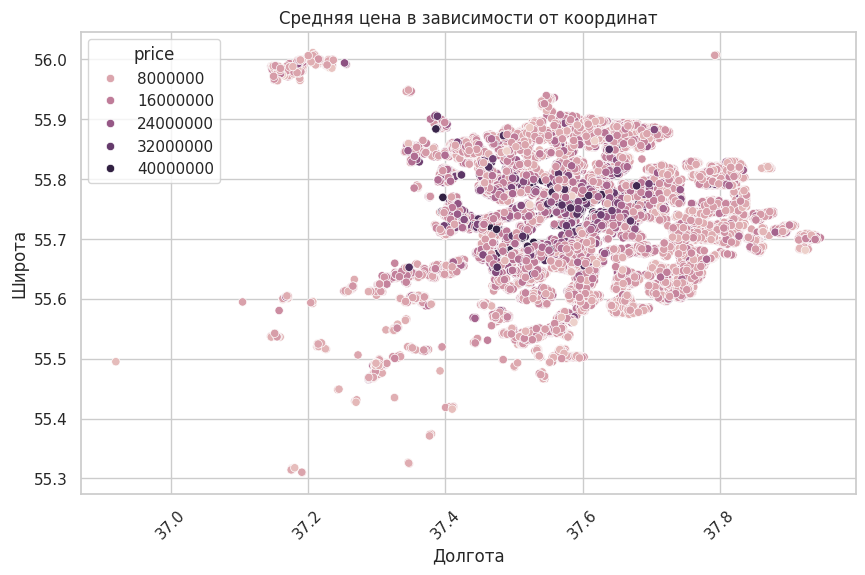

In [20]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='longitude', y='latitude', hue=target_col, data=data)
plt.title('Средняя цена в зависимости от координат')
plt.xlabel('Долгота')
plt.ylabel('Широта')
plt.xticks(rotation=45)

plt.savefig(os.path.join(ASSETS_DIR, 'longitude_latitude_price_correlation.png'))
plt.show()


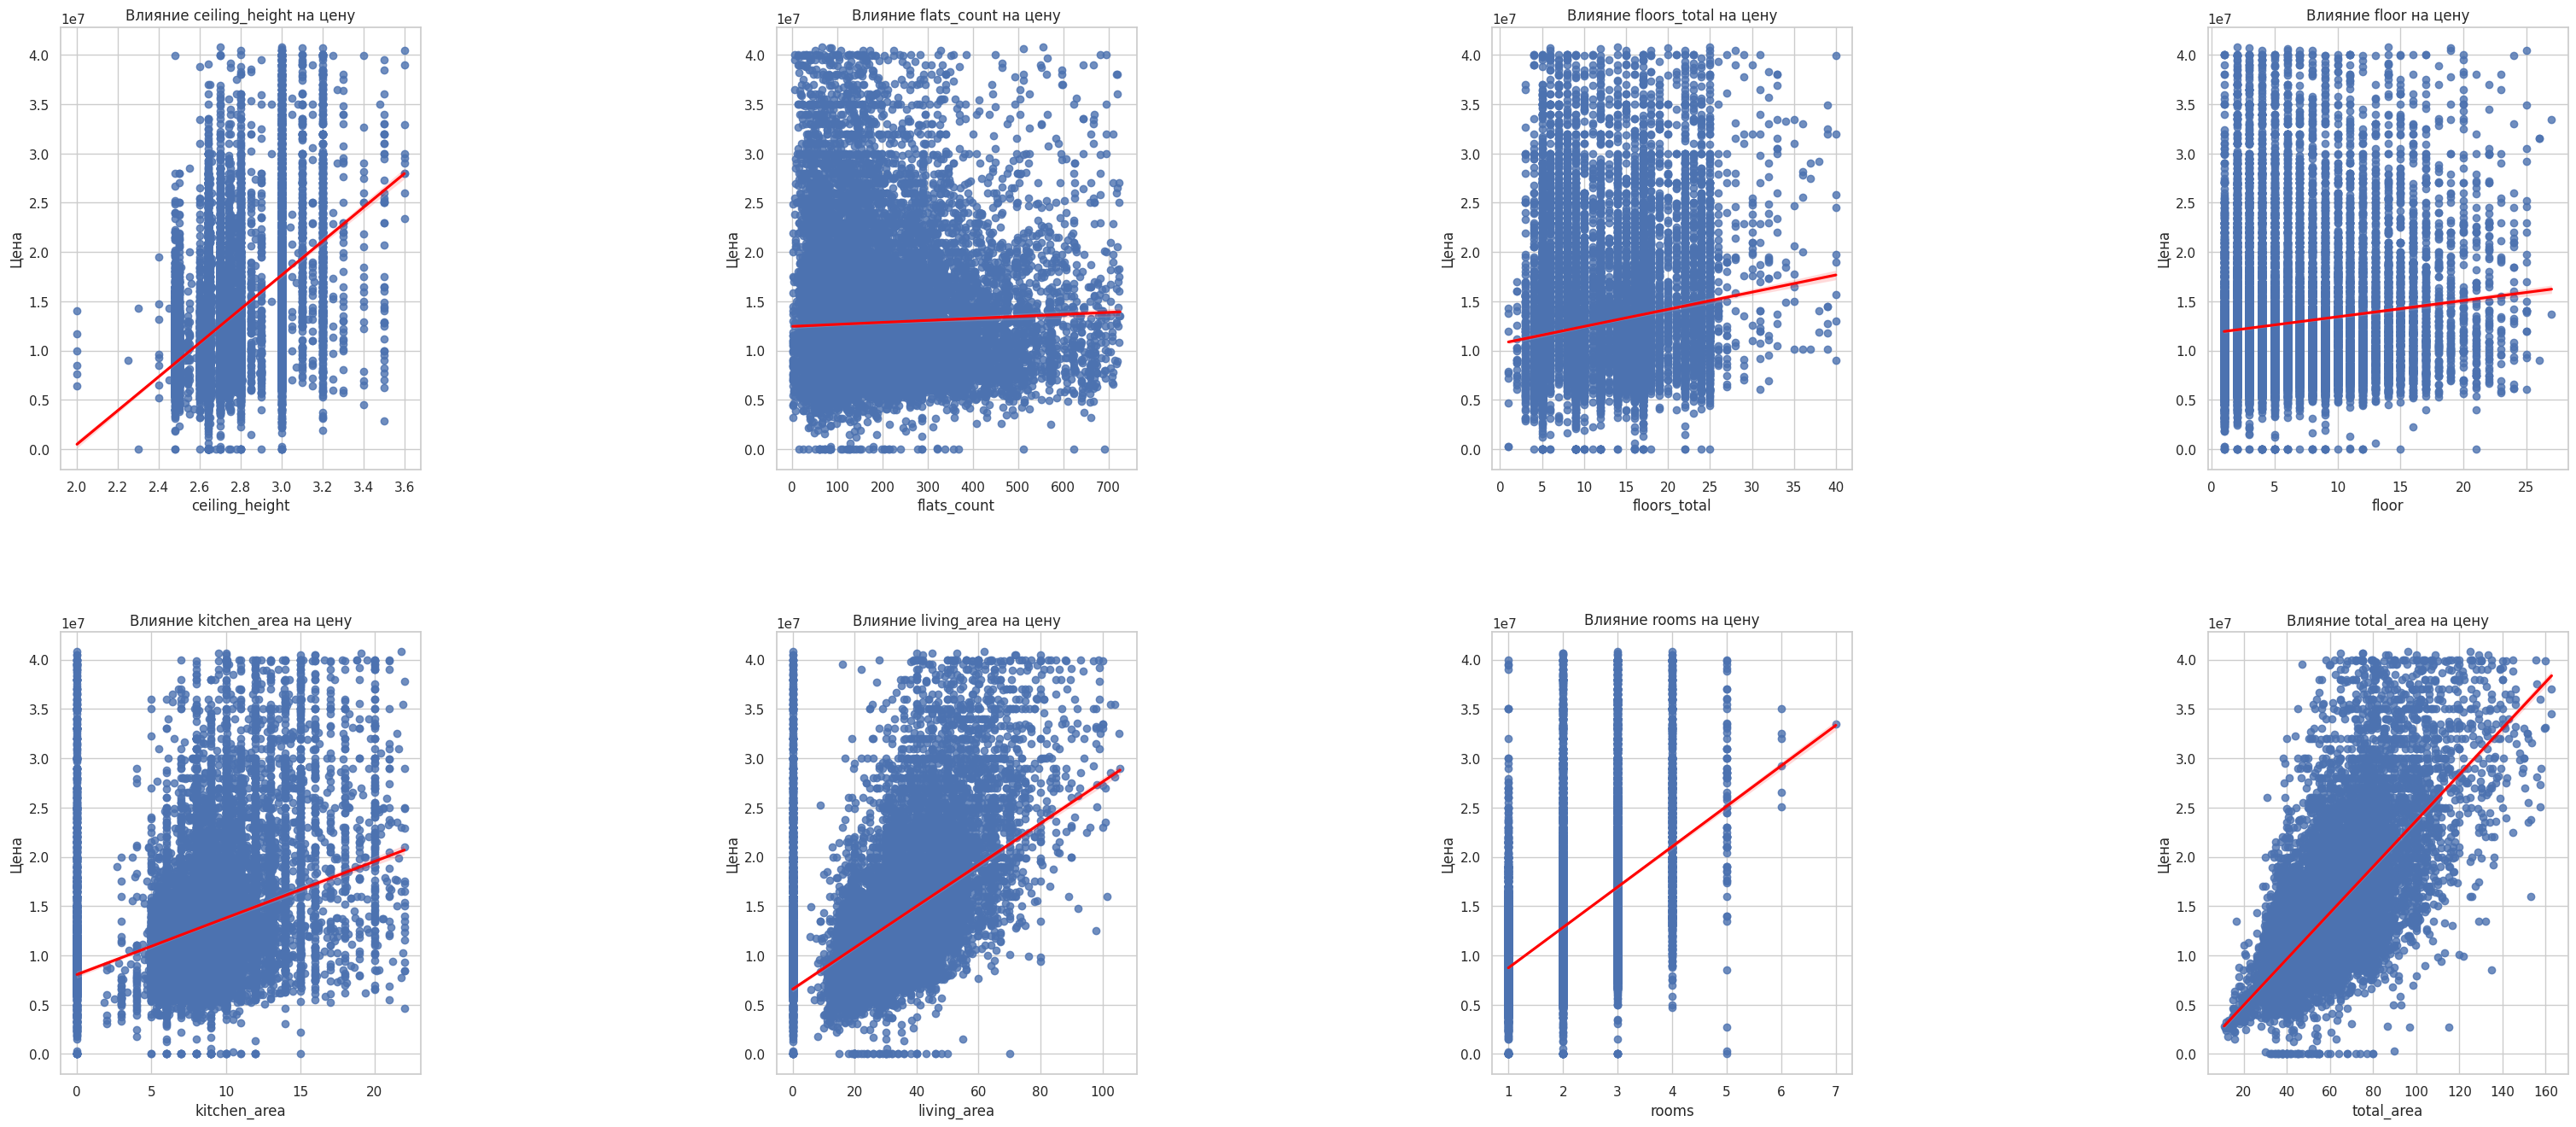

In [21]:
pairplot_features = [
    'ceiling_height',
    'flats_count',
    'floors_total',
    'floor',
    'kitchen_area',
    'living_area',
    'rooms',
    'total_area'
]

fig, ax = plt.subplots(2,4)
fig.tight_layout(pad=1.6)  # настройка отступов между подграфиками
fig.set_size_inches(35, 15, forward=True)  # установка размера фигуры

for i, feature in enumerate(pairplot_features):
    sns.regplot(data=data, x=feature, y=target_col, line_kws={'color': 'red'}, ax=ax[i//4, i%4])
    ax[i//4, i%4].set_title(f'Влияние {feature} на цену')
    ax[i//4, i%4].set_xlabel(feature)
    ax[i//4, i%4].set_ylabel('Цена')

plt.savefig(os.path.join(ASSETS_DIR, 'features_price_correlation.png'))
plt.show()


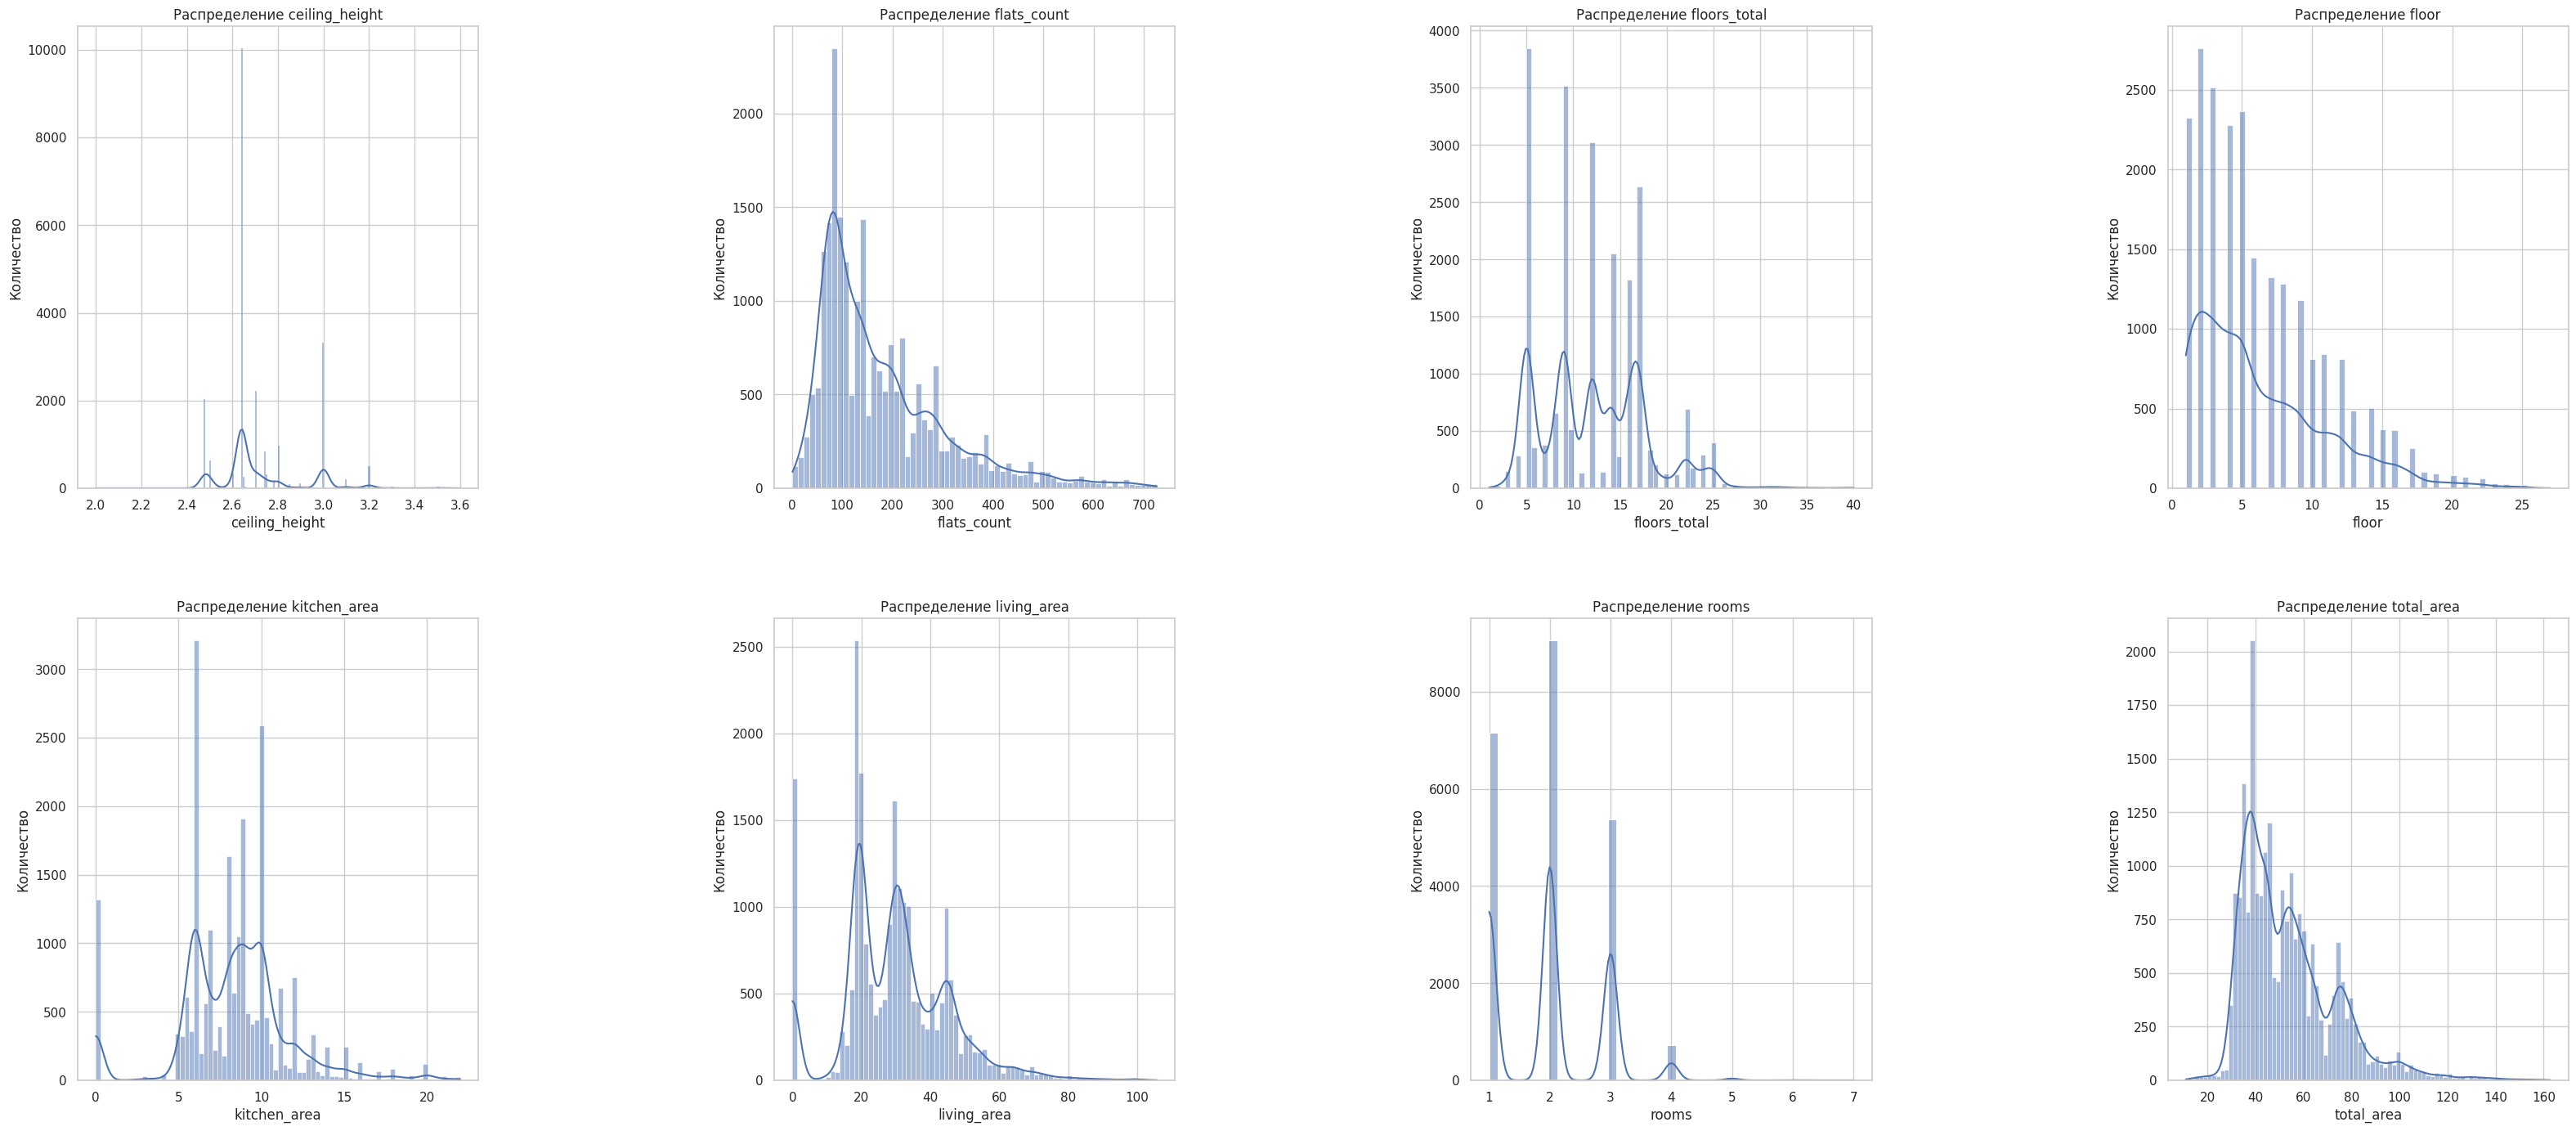

In [22]:
histplot_features = [
    'ceiling_height',
    'flats_count',
    'floors_total',
    'floor',
    'kitchen_area',
    'living_area',
    'rooms',
    'total_area'
]

fig, ax = plt.subplots(2,4)
fig.tight_layout(pad=1)  # настройка отступов между подграфиками
fig.set_size_inches(35, 15, forward=True)  # установка размера фигуры

for i, feature in enumerate(histplot_features):
    sns.histplot(data=data, x=feature, kde=True, ax=ax[i//4, i%4])
    ax[i//4, i%4].set_title(f'Распределение {feature}')
    ax[i//4, i%4].set_xlabel(feature)
    ax[i//4, i%4].set_ylabel('Количество')

plt.savefig(os.path.join(ASSETS_DIR, 'numeric_features_histplot.png'))

plt.show()

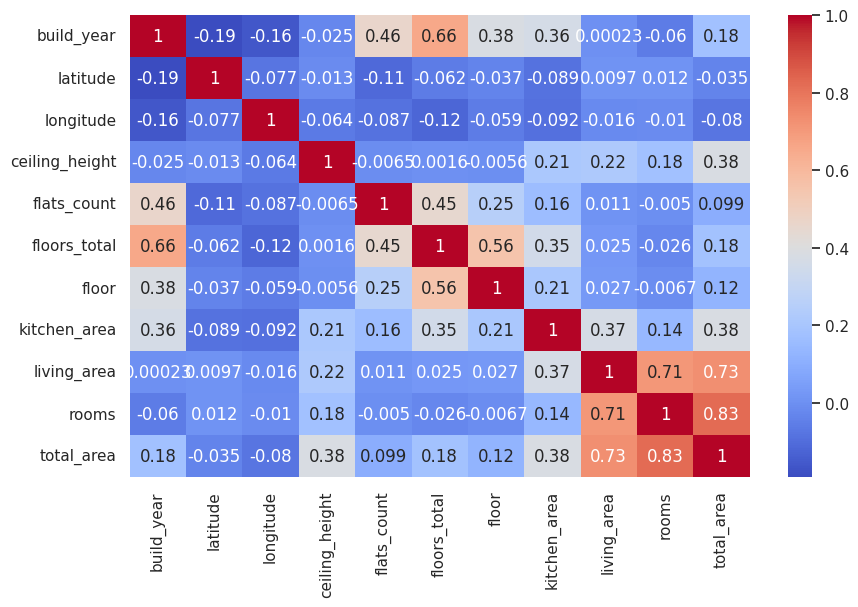

In [23]:
plt.figure(figsize=(10, 6))
cor_matrix = data[numeric_features].corr()
sns.heatmap(cor_matrix, annot=True, cmap='coolwarm')

plt.savefig(os.path.join(ASSETS_DIR, 'numeric_features_cor_matrix.png'))
plt.show()



In [24]:
# 2.4 Анализ целевой переменной

In [25]:
median_price = data[target_col].median()
mean_price = data[target_col].mean()
max_price = data[target_col].max()
min_price = data[target_col].min()
q_25 = data[target_col].quantile(0.25)
q_75 = data[target_col].quantile(0.75)

print('Описательная статистика целевой переменной:\n')
print(f'Медиана: {round(median_price)}')
print(f'Среднее: {round(mean_price)}')
print(f'Максимум: {round(max_price)}')
print(f'Минимум: {round(min_price)}')
print(f'25-й квартиль: {round(q_25)}')
print(f'75-й квартиль: {round(q_75)}')


Описательная статистика целевой переменной:

Медиана: 11100000
Среднее: 12821864
Максимум: 40800000
Минимум: 85
25-й квартиль: 8500000
75-й квартиль: 15000000


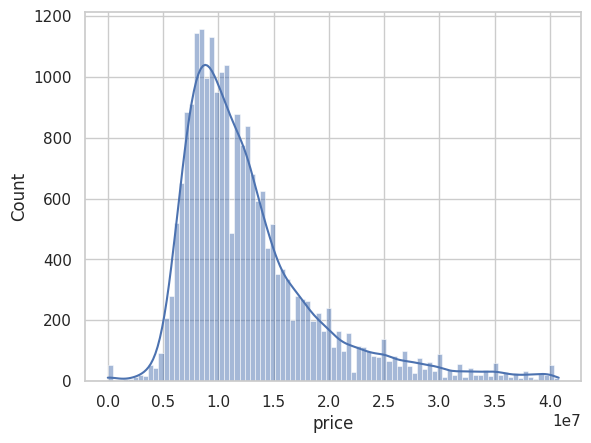

In [26]:
sns.histplot(data=data, x=target_col, kde=True)

plt.savefig(os.path.join(ASSETS_DIR, 'target_variable_histplot.png'))
plt.show()


In [27]:
# 2.4 Анализ целевой переменной в зависимости от различных признаков

2025-06-08 18:41:47,523 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-06-08 18:41:47,543 INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


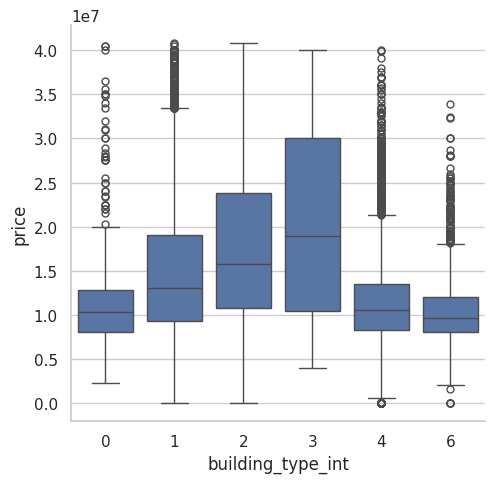

In [28]:
sns.catplot(kind='box', data=data, y=target_col, x='building_type_int')
plt.savefig(os.path.join(ASSETS_DIR, 'target_variable_boxplot'))
plt.show()


In [29]:
binary_features

['has_elevator', 'is_apartment', 'studio']

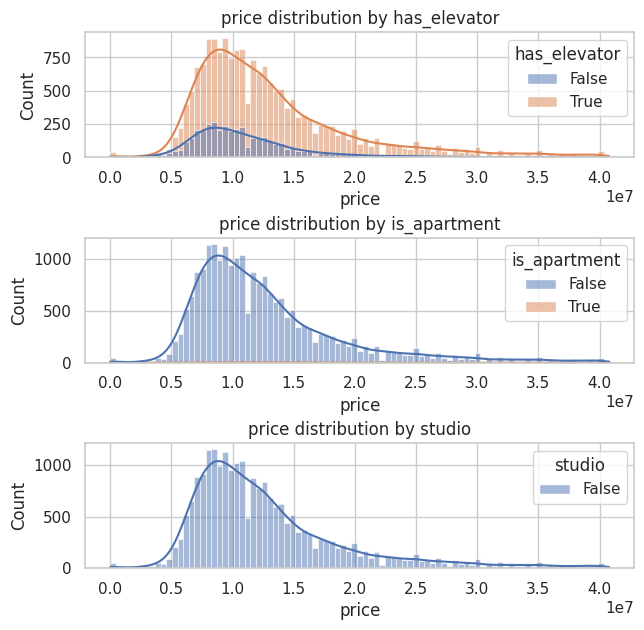

In [30]:
# инициализация фигуры для отображения гистограмм
fig, axs = plt.subplots(3, 1)
fig.tight_layout(pad=1.5)  # настройка отступов между подграфиками
fig.set_size_inches(6.5, 6.5, forward=True)  # установка размера фигуры

sns.histplot(data=data, x=target_col, hue=binary_features[0], ax=axs[0], kde=True)
axs[0].set_title(f"{target_col} distribution by {binary_features[0]}")  # установка заголовка для гистограммы

sns.histplot(data=data, x=target_col, hue=binary_features[1], ax=axs[1], kde=True)
axs[1].set_title(f"{target_col} distribution by {binary_features[1]}")  # Установка заголовка для второй гистограммы

sns.histplot(data=data, x=target_col, hue=binary_features[2], ax=axs[2], kde=True)
axs[2].set_title(f"{target_col} distribution by {binary_features[2]}")  # Установка заголовка для второй гистограммы

# сохранение фигуры с гистограммами в файл
plt.savefig(os.path.join(ASSETS_DIR, "target_variable_by_binary_features_dist.png"))

In [31]:
# 2.5 Выводы после EDA

**Выводы по числовым признакам:**
1. Наибольшая стоимость квартир наблюдается в центральных значениях longitude и latitude. Если прогуглить, то видно, что это центр Москвы) В целом, данные фичи можно перевести в категориальные, взяв диапазон центральных значений и обозначив их как центр, а остальные использовать для идентификации окраины.

2. По годам постройки очень интересная ситуация: дома до 1960 года стоят дороже, чем современные, дома с 1960 по 2000, наоборот, дешевле. Это связано с тем, что очень старые дома считаются раритетом и стоят дорого, а современные дома, наоборот, модные и современные, поэтому снова стоят дорого, интервал с 60х по 00е - это постройки старого фонда.

3. Наибольшую линейную корреляцию с ценой можно увидеть у переменных, обозначающих размер квартиры: living_area, rooms, total_area. При этом, данные признаки сильно коррелируют друг с другом.

4. Чем современнее дом, тем в среднем больше этажей в доме, об этом свидетельствует корреляция build_year и total_floor.

**Выводы по категориальным признакам:**
1. В датасете не представлены квартиры-студии.

2. Наибольшую стоимость представляют квартиры с building_type_int 2 и 3.

3. В данных очень мало представлено квартир-апартаментов.


In [31]:
conclusions   ="""
**Выводы по числовым признакам:**
1. Наибольшая стоимость квартир наблюдается в центральных значениях longitude и latitude. Если прогуглить, то видно, что это центр Москвы) В целом, данные фичи можно перевести в категориальные, взяв диапазон центральных значений и обозначив их как центр, а остальные использовать для идентификации окраины.

2. По годам постройки очень интересная ситуация: дома до 1960 года стоят дороже, чем современные, дома с 1960 по 2000, наоборот, дешевле. Это связано с тем, что очень старые дома считаются раритетом и стоят дорого, а современные дома, наоборот, модные и современные, поэтому снова стоят дорого, интервал с 60х по 00е - это постройки старого фонда.

3. Наибольшую линейную корреляцию с ценой можно увидеть у переменных, обозначающих размер квартиры: living_area, rooms, total_area. При этом, данные признаки сильно коррелируют друг с другом.

4. Чем современнее дом, тем в среднем больше этажей в доме, об этом свидетельствует корреляция build_year и total_floor.

**Выводы по категориальным признакам:**
1. В датасете не представлены квартиры-студии.

2. Наибольшую стоимость представляют квартиры с building_type_int 2 и 3.

3. В данных очень мало представлено квартир-апартаментов.
"""

# Запись в .md файл
with open(os.path.join(ASSETS_DIR, "conclusions.md"), "w", encoding="utf-8") as f:
    f.write(conclusions)

In [ ]:
# 2.6 логирование артефактов в MLflow

In [33]:
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
RUN_NAME = "eda"

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    mlflow.log_artifact("improvement_experiments.ipynb")
    mlflow.log_artifacts(ASSETS_DIR) 

In [121]:
run_id

'bfd63aa0e0154e88ab903783f0c1ada6'

#### Этап 3: Генерация Признаков и Обучение Новой Версии Модели
После тщательного исследовательского анализа данных (EDA), вы, скорее всего, сформировали несколько гипотез относительно новых признаков, которые могут улучшить качество вашей модели. На этом этапе, мы предлагаем вам приступить к генерации новых признаков и последующему обучению модели, используя два подхода:

Ручная генерация признаков: Используйте ваше понимание данных и результаты EDA для создания новых признаков.
Автоматическая генерация признаков: Воспользуйтесь библиотеками для автоматической генерации признаков, чтобы облегчить и ускорить этот процесс.
Важно: Для признаков, созданных вручную, рекомендуется использовать объекты sklearn, такие как Pipeline и ColumnTransformer. Это позволит автоматизировать процесс преобразования данных и облегчить поддержку вашего проекта.

После генерации новых признаков, наступает время обучить новую версию вашей модели, используя эти признаки. Не забудьте залогировать все результаты, включая новые признаки, параметры модели и метрики качества, в MLflow для удобства отслеживания изменений и результатов.

Рекомендуемые шаги:

- Определение и генерация новых признаков на основе ваших гипотез.
- Использование библиотек для автоматической генерации признаков, если это применимо.
- Интеграция новых признаков в вашу модель с помощью Pipeline или ColumnTransformer для ручно созданных признаков.
- Обучение новой версии модели с использованием всех доступных признаков.
- Логирование результатов в MLflow для документирования и анализа эффективности новых признаков и модели.

Этот этап проекта критически важен для повышения точности и эффективности вашей модели. Тщательная работа на этом этапе может существенно повлиять на итоговое качество моделирования.


In [32]:
# 3.1 ручная генерация признаков

In [33]:
# определяем координаты центра города

long_center_low = 37.5
long_center_high = 37.7
lat_center_low = 55.7
lat_center_high = 55.8

data['is_center'] = data['longitude'].between(long_center_low, long_center_high) & data['latitude'].between(lat_center_low, lat_center_high)

In [34]:
data[['is_center', target_col]].corr()

,is_center,price
is_center,1.000000,0.366628
price,0.366628,1.000000


In [35]:
binary_features.append('is_center')

In [36]:
# делим дома по дате строительства

def building_age(build_year: int) -> str:
    
    if build_year < 1960:
        return 'retro'
    elif build_year < 2000:
        return 'old'
    else:
        return 'modern'

building_age_vector = np.vectorize(building_age)

data['age_type'] = building_age_vector(data['build_year'])

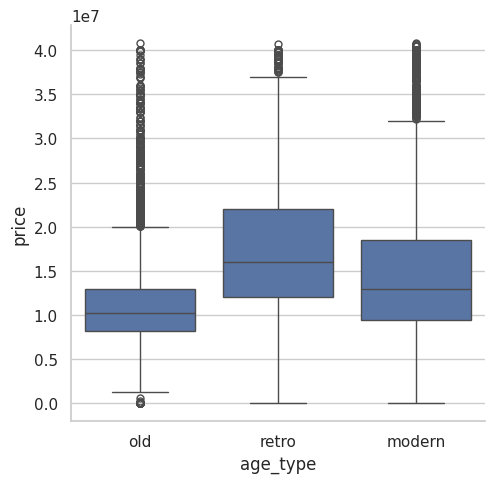

In [37]:
sns.catplot(kind='box', data=data, y=target_col, x='age_type')
plt.show()

In [38]:
categorical_features.append('age_type')

In [40]:
print('категориальные признаки:', categorical_features)
print('числовые признаки:', numeric_features)
print('бинарные признаки:', binary_features)


категориальные признаки: ['building_type_int', 'age_type']
числовые признаки: ['build_year', 'latitude', 'longitude', 'ceiling_height', 'flats_count', 'floors_total', 'floor', 'kitchen_area', 'living_area', 'rooms', 'total_area']
бинарные признаки: ['has_elevator', 'is_apartment', 'studio', 'is_center']


In [41]:
# препроцессинг категориальных признаков

encoder_ohe = OneHotEncoder(categories='auto', handle_unknown='ignore', max_categories=10, sparse_output=False, drop='first')
encoder_ohe.fit(data[categorical_features + binary_features].to_numpy())
categorical_features_encoded = encoder_ohe.fit_transform(data[categorical_features + binary_features].to_numpy())
categorical_features_encoded_df = pd.DataFrame(categorical_features_encoded, columns=encoder_ohe.get_feature_names_out())


categorical_features_encoded_df.head(10)



,x0_1,x0_2,x0_3,x0_4,x0_6,x1_old,x1_retro,x2_True,x3_True,x5_True
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
5,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
7,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
8,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
9,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [42]:
# препроцессинг числовых признаков

num_df = data[numeric_features]

bins_columns = ['longitude', 'latitude']
quantile_columns = ['total_area', 'living_area', 'kitchen_area']
poly_columns = ['flats_count', 'floors_total', 'floor', 'rooms', 'ceiling_height']
robust_columns = ['build_year', 'ceiling_height']

n_quantiles=50
n_bins = 5
degree = 2

# KBinsDiscretizer
encoder_bin = KBinsDiscretizer(n_bins=n_bins, encode='ordinal')
encoded_features = encoder_bin.fit_transform(data[bins_columns].to_numpy())

encoded_df = pd.DataFrame(encoded_features, columns=encoder_bin.get_feature_names_out(bins_columns))
# encoded_df.columns = [col + f"_bin_{n_bins}" for col in bins_columns]
num_df = pd.concat([num_df, encoded_df], axis=1)

# QuantileTransformer
encoder_q = QuantileTransformer(n_quantiles=n_quantiles)
encoded_features = encoder_q.fit_transform(data[quantile_columns].to_numpy())
encoded_df = pd.DataFrame(encoded_features, columns=encoder_q.get_feature_names_out(quantile_columns))
# encoded_df.columns = [col + f"_q_{n_quantiles}" for col in quantile_columns]
num_df = pd.concat([num_df, encoded_df], axis=1)


# PolynomialFeatures
encoder_p = PolynomialFeatures(degree=degree)
encoded_features = encoder_p.fit_transform(data[poly_columns].to_numpy())
encoded_df = pd.DataFrame(encoded_features, columns=encoder_p.get_feature_names_out(poly_columns))
# encoded_df.columns = [col + f"_poly_{degree}" for col in poly_columns]
num_df = pd.concat([num_df, encoded_df], axis=1)


# RobustScaler
encoder_r = RobustScaler()
encoded_features = encoder_r.fit_transform(data[robust_columns].to_numpy())
encoded_df = pd.DataFrame(encoded_features, columns=encoder_r.get_feature_names_out(robust_columns))
# encoded_df.columns = [col + f"_robust" for col in robust_columns]
num_df = pd.concat([num_df, encoded_df], axis=1)


num_df.head(2)

,build_year,latitude,longitude,ceiling_height,flats_count,floors_total,floor,kitchen_area,living_area,rooms,total_area,longitude,latitude,total_area,living_area,kitchen_area,1,flats_count,floors_total,floor,rooms,ceiling_height,flats_count^2,flats_count floors_total,flats_count floor,flats_count rooms,flats_count ceiling_height,floors_total^2,floors_total floor,floors_total rooms,floors_total ceiling_height,floor^2,floor rooms,floor ceiling_height,rooms^2,rooms ceiling_height,ceiling_height^2,build_year,ceiling_height
1,1961.0,55.706188,37.740948,2.64,60.0,5.0,3.0,6.0,30.0,2.0,41.0,1.0,0.0,0.591837,0.673469,0.602041,1.0,256.0,16.0,5.0,2.0,2.64,65536.0,4096.0,1280.0,512.0,675.840027,256.0,80.0,32.0,42.240002,25.0,10.0,13.200001,4.0,5.28,6.969601,0.085714,0.0
2,1979.0,55.618950,37.540848,2.64,256.0,16.0,5.0,9.0,34.0,2.0,54.0,4.0,1.0,0.636054,0.571429,0.744898,1.0,203.0,17.0,6.0,2.0,2.64,41209.0,3451.0,1218.0,406.0,535.920021,289.0,102.0,34.0,44.880002,36.0,12.0,15.840001,4.0,5.28,6.969601,0.200000,0.0


In [43]:
# 3.2 оборачивание всех преобразований в объекты sklearn

In [44]:
numeric_transformer = ColumnTransformer(transformers=[
    ('kbin', encoder_bin, bins_columns),
    ('q', encoder_q, quantile_columns),
    ('pol', encoder_p, poly_columns),
    ('rb', encoder_r, robust_columns)
    ])

categorical_transformer = ColumnTransformer(transformers=[('ohe', encoder_ohe, categorical_features + binary_features)])

preprocessor = ColumnTransformer(transformers=[('num', numeric_transformer, numeric_features), ('cat', categorical_transformer, categorical_features + binary_features)], n_jobs=-1)

encoded_features = preprocessor.fit_transform(data)

transformed_df = pd.DataFrame(encoded_features, columns=preprocessor.get_feature_names_out())

transformed_df.head(5)

,num__kbin__longitude,num__kbin__latitude,num__q__total_area,num__q__living_area,num__q__kitchen_area,num__pol__1,num__pol__flats_count,num__pol__floors_total,num__pol__floor,num__pol__rooms,num__pol__ceiling_height,num__pol__flats_count^2,num__pol__flats_count floors_total,num__pol__flats_count floor,num__pol__flats_count rooms,num__pol__flats_count ceiling_height,num__pol__floors_total^2,num__pol__floors_total floor,num__pol__floors_total rooms,num__pol__floors_total ceiling_height,num__pol__floor^2,num__pol__floor rooms,num__pol__floor ceiling_height,num__pol__rooms^2,num__pol__rooms ceiling_height,num__pol__ceiling_height^2,num__rb__build_year,num__rb__ceiling_height,cat__ohe__building_type_int_1,cat__ohe__building_type_int_2,cat__ohe__building_type_int_3,cat__ohe__building_type_int_4,cat__ohe__building_type_int_6,cat__ohe__age_type_old,cat__ohe__age_type_retro,cat__ohe__has_elevator_True,cat__ohe__is_apartment_True,cat__ohe__is_center_True
0,4.0,1.0,0.324675,0.520408,0.193878,1.0,60.0,5.0,3.0,2.0,2.64,3600.0,300.0,180.0,120.0,158.400006,25.0,15.0,10.0,13.200001,9.0,6.0,7.920000,4.0,5.28,6.969601,-0.428571,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.591837,0.673469,0.581633,1.0,256.0,16.0,5.0,2.0,2.64,65536.0,4096.0,1280.0,512.0,675.840027,256.0,80.0,32.0,42.240002,25.0,10.0,13.200001,4.0,5.28,6.969601,0.085714,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
2,4.0,1.0,0.632653,0.575510,0.744898,1.0,203.0,17.0,6.0,2.0,2.64,41209.0,3451.0,1218.0,406.0,535.920021,289.0,102.0,34.0,44.880002,36.0,12.0,15.840001,4.0,5.28,6.969601,0.200000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
3,4.0,2.0,0.428571,0.489796,0.336735,1.0,431.0,9.0,1.0,2.0,2.64,185761.0,3879.0,431.0,862.0,1137.840045,81.0,9.0,18.0,23.760001,1.0,2.0,2.640000,4.0,5.28,6.969601,-0.085714,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
4,4.0,3.0,0.245578,0.381789,0.272789,1.0,98.0,14.0,1.0,2.0,2.64,9604.0,1372.0,98.0,196.0,258.720010,196.0,14.0,28.0,36.960001,1.0,2.0,2.640000,4.0,5.28,6.969601,-0.142857,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [45]:
# 3.3 автоматическая генерация признаков

In [48]:
features = categorical_features + numeric_features

transformations = ('1/', 'log', 'abs', 'sqrt')

afc = AutoFeatRegressor(categorical_cols=categorical_features, transformations=transformations, feateng_steps=1, n_jobs=-1)

afc.fit(data[features], data[target_col])

autofeat_df = afc.transform(data[features])
data = pd.concat([data, autofeat_df[[col for col in autofeat_df.columns if col not in data.columns]]], axis=1)

data.head(5)

,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,is_apartment,kitchen_area,living_area,rooms,studio,total_area,price,is_center,age_type,cat_building_type_int_0,cat_building_type_int_1,cat_building_type_int_2,cat_building_type_int_3,cat_building_type_int_4,cat_building_type_int_6,cat_age_type_modern,cat_age_type_old,cat_age_type_retro,1/floor,1/total_area,1/floors_total,1/flats_count
1,1961.0,1.0,55.706188,37.740948,2.64,60.0,5.0,False,3.0,False,6.00,30.000000,2.0,False,41.00,10400000.0,False,old,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.200000,0.018519,0.062500,0.003906
2,1979.0,4.0,55.618950,37.540848,2.64,256.0,16.0,True,5.0,False,9.00,34.000000,2.0,False,54.00,10500000.0,False,old,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.166667,0.017857,0.058824,0.004926
3,1983.0,4.0,55.670040,37.742149,2.64,203.0,17.0,True,6.0,False,10.00,31.000000,2.0,False,56.00,12200000.0,False,old,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.000000,0.022222,0.111111,0.002320
4,1973.0,4.0,55.763409,37.825542,2.64,431.0,9.0,True,1.0,False,7.00,29.000000,2.0,False,45.00,7300000.0,False,old,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.000000,0.026096,0.071429,0.010204
5,1971.0,4.0,55.806629,37.806507,2.64,98.0,14.0,True,1.0,False,6.21,23.790001,2.0,False,38.32,9000000.0,False,old,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.000000,0.013477,0.058824,0.002160


In [181]:
data.columns

Index(['build_year', 'building_type_int', 'latitude', 'longitude',
       'ceiling_height', 'flats_count', 'floors_total', 'has_elevator',
       'floor', 'is_apartment', 'kitchen_area', 'living_area', 'rooms',
       'studio', 'total_area', 'price', 'is_center', 'age_type',
       'cat_building_type_int_0', 'cat_building_type_int_1',
       'cat_building_type_int_2', 'cat_building_type_int_3',
       'cat_building_type_int_4', 'cat_building_type_int_6',
       'cat_age_type_modern', 'cat_age_type_old', 'cat_age_type_retro',
       '1/floor', '1/total_area', '1/floors_total', '1/flats_count'],
      dtype='object')

In [ ]:
data.dropna(inplace=True)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=target_col), data[target_col], test_size=0.2, random_state=42)

In [60]:
# 3.4 обучение новой версии модели

In [61]:
model = CatBoostRegressor(iterations=300, verbose=False)

In [ ]:
pipe = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

pipe.fit(X_train, y_train)

prediction = pipe.predict(X_test)

mse = mean_squared_error(y_test, prediction, squared=False)
r2 = r2_score(y_test, prediction)
mae = mean_absolute_error(y_test, prediction)
mape = mean_absolute_percentage_error(y_test, prediction)

print(f'RMSE: {mse}')
print(f'R2: {r2}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

RMSE: 3270383.7006907007
R2: 0.7312576668632407
MAE: 2358708.932727545
MAPE: 1.8406835217682458


/home/mle-user/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [63]:
# 3.5 логирование артефактов в MLflow

In [64]:
EXPERIMENT_NAME

'real_estate_model_alexdem'

In [68]:
RUN_NAME = "improved_model_real_estate"
REGISTRY_MODEL_NAME = "model_real_estate_alexndem"

pip_requirements= "../requirements.txt"
signature = mlflow.models.infer_signature(X_test.values, prediction)
input_example = X_test[:10]


experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    model_info = mlflow.sklearn.log_model( 
			      pipe,
            artifact_path="models",
            registered_model_name=REGISTRY_MODEL_NAME,
            pip_requirements=pip_requirements,
            signature=signature,
            input_example=input_example,
            await_registration_for=60
		)
    mlflow.log_metrics({'mse': mse, 'r2': r2, 'mae': mae})
    mlflow.log_artifact("improvement_experiments.ipynb")

2025-06-08 18:49:57,885 INFO: Found credentials in environment variables.


Registered model 'model_real_estate_alexndem' already exists. Creating a new version of this model...
2025/06/08 18:49:59 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: model_real_estate_alexndem, version 3
Created version '3' of model 'model_real_estate_alexndem'.


#### Этап 4: Отбор Признаков и Обучение Новой Версии Модели
Создание новых признаков — это лишь часть работы. Следующий важный шаг — это убедиться в том, что каждый из этих признаков действительно вносит положительный вклад в качество модели. Некоторые признаки могут оказывать отрицательное влияние на модель, поэтому их следует исключить из анализа.

На этом этапе, мы рекомендуем вам применить различные методы отбора признаков для того, чтобы определить и удалить те признаки, которые не улучшают качество вашей модели. Цель этого этапа — максимизировать производительность модели, удалив избыточные или неинформативные признаки.

После тщательного отбора признаков, пора обучить новую версию вашей модели, уже без негативно влияющих на неё признаков. Важно залогировать результаты этого этапа, включая измененный набор признаков, параметры модели и полученные метрики качества, в MLflow для последующего анализа и сравнения.

Рекомендуемые шаги:

- Применение методов отбора признаков для идентификации и исключения признаков, ухудшающих качество модели.
- Анализ влияния каждого признака на модель, чтобы понять, какие из них наиболее ценные.
- Обучение новой версии модели без негативно влияющих признаков.
- Логирование всех изменений и результатов в MLflow, включая конечный набор признаков, параметры модели и метрики качества.

Этот этап не только поможет улучшить качество вашей модели, но и даст глубокое понимание о важности и влиянии отдельных признаков на результаты моделирования.


In [ ]:
# 4.1 Отбор признаков при помощи метода номер 1

In [82]:
# получение признаков из pipeline

X_train_features = pipe['preprocessor'].fit_transform(X_train)
X_train_features = pd.DataFrame(X_train_features, columns=preprocessor.get_feature_names_out())

In [99]:
X_test_features = pipe['preprocessor'].transform(X_test)
X_test_features = pd.DataFrame(X_test_features, columns=preprocessor.get_feature_names_out())


Уменьшим количество признаков, убрав полиномы, чтобы время подбора признаков было приемлемым

In [87]:
X_train_features = X_train_features[[col for col in X_train_features.columns if '_pol_' not in col]]

In [100]:
X_test_features = X_test_features[[col for col in X_test_features.columns if '_pol_' not in col]]

In [88]:
estimator = CatBoostRegressor(n_estimators=100, verbose=False)

sfs = SFS(estimator, k_features=10, forward=True, floating=False, scoring='neg_mean_squared_error', verbose=2, cv=3, n_jobs=-1)

sfs = sfs.fit(X_train_features, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.

[2025-06-08 19:03:19] Features: 1/10 -- score: -19568416644264.688[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.

[2025-06-08 19:03:30] Features: 2/10 -- score: -15800086087405.984[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.

[2025-06-08 19:03:41] Features: 3/10 -- score: -14765049245353.24[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.

[2025-06-08 19:03:53] Features: 4/10 -- score: -13010406294781.875[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.

[2025-06-08 19:04:03] Features: 5/10 -- score: -12022559504093.865[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.

[2025-06-08 19:04:14] Features: 6/10 -- score: -11612112822770.541[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.

[2025-06-08 19:04:24] Features: 7/10 -- score: -11546987927241.799

In [90]:
top_sfs = sfs.k_feature_names_
print('\nSequential Forward Selection (k=10)')
print('CV Score:')
print(sfs.k_score_)
print('\nFeatures:')
print(top_sfs)



Sequential Forward Selection (k=10)
CV Score:
-11458405490605.588

Features:
('num__kbin__longitude', 'num__kbin__latitude', 'num__q__total_area', 'num__rb__build_year', 'num__rb__ceiling_height', 'cat__ohe__building_type_int_1.0', 'cat__ohe__building_type_int_4.0', 'cat__ohe__age_type_retro', 'cat__ohe__has_elevator_True', 'cat__ohe__is_center_True')


In [ ]:
# 4.2 Отбор признаков при помощи метода номер 2

In [91]:
estimator = CatBoostRegressor(n_estimators=100, verbose=False)

sbs = SFS(estimator, k_features=10, forward=False, floating=False, scoring='neg_mean_squared_error', verbose=2, cv=3, n_jobs=-1)

sbs = sbs.fit(X_train_features, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.

[2025-06-08 19:08:18] Features: 16/10 -- score: -11467974242148.389[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.

[2025-06-08 19:08:37] Features: 15/10 -- score: -11400385585410.463[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.

[2025-06-08 19:08:54] Features: 14/10 -- score: -11421937004811.92[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.

[2025-06-08 19:09:10] Features: 13/10 -- score: -11371075522066.48[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.

[2025-06-08 19:09:24] Features: 12/10 -- score: -11350025682366.03[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.

[2025-06-08 19:09:37] Features: 11/10 -- score: -11365366207036.877[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.

[2025-06-08 19:09:47] Features: 10/10 -- score: -1140279015853

In [92]:
top_sbs = sbs.k_feature_names_
print('\nSequential Backward Selection (k=10)')
print('CV Score:')
print(sbs.k_score_)
print('\nFeatures:')
print(top_sbs)


Sequential Backward Selection (k=10)
CV Score:
-11402790158530.137

Features:
('num__kbin__longitude', 'num__kbin__latitude', 'num__q__total_area', 'num__rb__build_year', 'num__rb__ceiling_height', 'cat__ohe__building_type_int_4.0', 'cat__ohe__age_type_retro', 'cat__ohe__has_elevator_True', 'cat__ohe__is_apartment_True', 'cat__ohe__is_center_True')


In [ ]:
# 4.3 Анализ отобранных признаков при помощи двух методов и формирование финального списка с признаками для модели

In [93]:
sfs_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
sbs_df = pd.DataFrame.from_dict(sbs.get_metric_dict()).T 

In [94]:
# сохранение результатов отбора признаков

sfs_df.to_csv(f"{ASSETS_DIR}/sfs.csv")
sbs_df.to_csv(f"{ASSETS_DIR}/sbs.csv") 

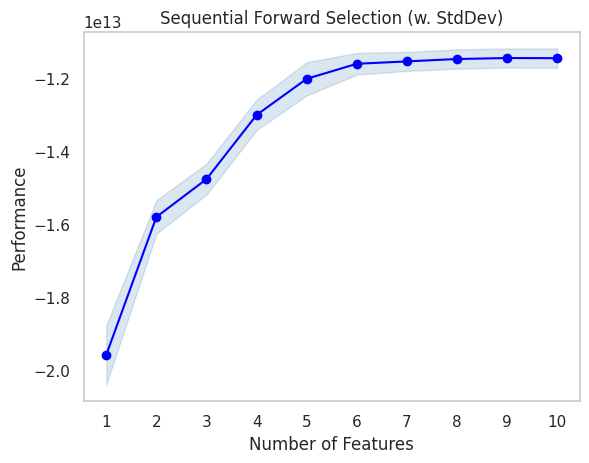

In [184]:

fig = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()

plt.savefig(f"{ASSETS_DIR}/sfs.png") 

Как видно из графика SFS, после 7 признаков качество модели практически не увеличивается

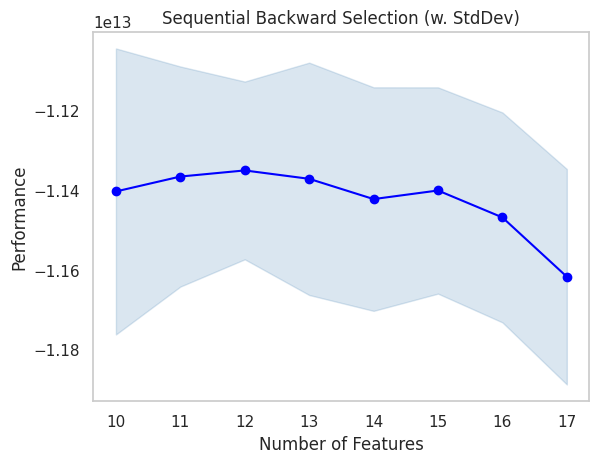

In [185]:
fig = plot_sfs(sbs.get_metric_dict(), kind='std_dev')

plt.title('Sequential Backward Selection (w. StdDev)')
plt.grid()

plt.savefig(f"{ASSETS_DIR}/sbs.png") 

Судя по графику SBS после 12 признаков качество снижается

Таким образом, оптимальное количество признаков модели находится в диапазоне **7-12**

In [98]:
interc_features = list(set(top_sbs) & set(top_sfs))
union_features = list(set(top_sbs) | set(top_sfs))

print(f"Пересечение признаков: {interc_features}")
print(f"Объединение признаков: {union_features}")




Пересечение признаков: ['num__rb__build_year', 'cat__ohe__building_type_int_4.0', 'cat__ohe__age_type_retro', 'num__kbin__latitude', 'num__q__total_area', 'num__kbin__longitude', 'cat__ohe__is_center_True', 'num__rb__ceiling_height', 'cat__ohe__has_elevator_True']
Объединение признаков: ['cat__ohe__building_type_int_4.0', 'cat__ohe__building_type_int_1.0', 'cat__ohe__is_center_True', 'num__kbin__longitude', 'num__rb__ceiling_height', 'cat__ohe__has_elevator_True', 'num__rb__build_year', 'cat__ohe__age_type_retro', 'num__kbin__latitude', 'cat__ohe__is_apartment_True', 'num__q__total_area']


In [101]:
len(union_features)

11

In [106]:
# 4.4 Обучение новой версии модели

In [162]:
# обучение модели с оптимальным набором признаков
# для обучения будем использовать признаки, которые присутствуют хотя бы в одном из двух методов отбора признаков
model = CatBoostRegressor(n_estimators=300, verbose=False)

model.fit(X_train_features[union_features], y_train)

prediction = model.predict(X_test_features[union_features])

mse = mean_squared_error(y_test, prediction, squared=False)
r2 = r2_score(y_test, prediction)
mae = mean_absolute_error(y_test, prediction)
mape = mean_absolute_percentage_error(y_test, prediction)

print(f'RMSE: {mse}')
print(f'R2: {r2}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

RMSE: 3232499.736781149
R2: 0.7374478008232845
MAE: 2348708.3316938407
MAPE: 1.8410878942933646


/home/mle-user/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [107]:
# 4.5 Логирование всех артефактов в MLflow

In [105]:
RUN_NAME = "feature_selection_model_real_estate"
REGISTRY_MODEL_NAME = "model_real_estate_alexndem"

pip_requirements= "../requirements.txt"
signature = mlflow.models.infer_signature(X_test_features[union_features].values, prediction)
input_example = X_test_features[union_features][:10]


experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    model_info = mlflow.sklearn.log_model( 
			      pipe,
            artifact_path="models",
            registered_model_name=REGISTRY_MODEL_NAME,
            pip_requirements=pip_requirements,
            signature=signature,
            input_example=input_example,
            await_registration_for=60
		)
    mlflow.log_metrics({'mse': mse, 'r2': r2, 'mae': mae})
    mlflow.log_artifact("improvement_experiments.ipynb")
    mlflow.log_artifact(f"{ASSETS_DIR}/sbs.png")
    mlflow.log_artifact(f"{ASSETS_DIR}/sfs.png")
    mlflow.log_artifact(f"{ASSETS_DIR}/sbs.csv")
    mlflow.log_artifact(f"{ASSETS_DIR}/sfs.csv")



/home/mle-user/.local/lib/python3.10/site-packages/_distutils_hack/__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/mle-user/.local/lib/python3.10/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
Registered model 'model_real_estate_alexndem' already exists. Creating a new version of this model...
2025/06/08 19:32:49 INFO mlflow.trackin

### Этап 5 - подбор гиперпараметров и обучение новой версии модели
После того как мы уделили значительное внимание качеству модели через создание и отбор признаков, пришло время для финального штриха — подбора гиперпараметров. Этот этап является ключевым в финальной части проекта второго спринта, где ваша задача — оптимизировать гиперпараметры модели для достижения наилучшего качества.

Рекомендуется подобрать гиперпараметры как минимум двумя различными методами (например, с использованием Grid Search и Random Search), чтобы вы могли сравнить результаты и выбрать наиболее эффективный набор гиперпараметров для вашей модели. После определения оптимальных гиперпараметров, наступает время обучить финальную версию модели, используя ваши новые признаки.

Рекомендуемые шаги:

- Выбор методов для подбора гиперпараметров: Определитесь с методами, которые вы будете использовать для подбора гиперпараметров (например, Grid Search, Random Search, Bayesian Optimization).
- Подбор гиперпараметров: Примените выбранные методы для нахождения оптимальных значений гиперпараметров вашей модели.
- Сравнение результатов: Анализируйте и сравнивайте результаты, полученные различными методами, для определения наилучшего набора гиперпараметров.
- Обучение финальной модели: Используя выбранные гиперпараметры, обучите финальную версию вашей модели на новых признаках.
- Документирование процесса и результатов: Залогируйте все шаги и результаты в MLflow, включая сравнение методов подбора гиперпараметров и характеристики финальной модели.

Этот этап позволит вам максимально улучшить качество вашей модели перед финальной оценкой, предоставив полное понимание важности и влияния гиперпараметров на производительность модели.

In [ ]:
# 5.1 Подбор гиперпарметров при мощи метода номер 1

В качестве первого метода выберем Randomized Search, т.к. диапазон гиперпараметров широк

In [122]:
loss_function = "RMSE"
task_type = 'CPU'
random_seed = 0
iterations = 300
verbose = False

param_distributions = {
    'depth': [3, 7, 15],
    'learning_rate': [0.001, 0.01, 0.05, 0.1],
    'iterations': [100, 200, 300],
    'l2_leaf_reg': [1, 5, 20],
}

model = CatBoostRegressor(loss_function=loss_function, verbose=verbose, task_type=task_type, random_seed=random_seed)

cv = RandomizedSearchCV(estimator=model, param_distributions=param_distributions, n_iter=20, cv=2, scoring='neg_mean_squared_error', n_jobs=-1)

cv.fit(X_train_features[union_features], y_train)


RandomizedSearchCV(cv=2,
                   estimator=<catboost.core.CatBoostRegressor object at 0x7f6c04cf3d60>,
                   n_iter=20, n_jobs=-1,
                   param_distributions={'depth': [3, 7, 15],
                                        'iterations': [100, 200, 300],
                                        'l2_leaf_reg': [1, 5, 20],
                                        'learning_rate': [0.001, 0.01, 0.05,
                                                          0.1]},
                   scoring='neg_mean_squared_error')

In [147]:
cv.best_params_

{'learning_rate': 0.05, 'l2_leaf_reg': 5, 'iterations': 300, 'depth': 7}

In [148]:
cv_results = pd.DataFrame(cv.cv_results_)

best_params = cv.best_params_

model = CatBoostRegressor(**best_params, verbose=verbose, task_type=task_type, random_seed=random_seed)

model.fit(X_train_features[union_features], y_train)

prediction = model.predict(X_test_features[union_features])

mse = mean_squared_error(y_test, prediction, squared=False)
r2 = r2_score(y_test, prediction)
mae = mean_absolute_error(y_test, prediction)
mape = mean_absolute_percentage_error(y_test, prediction)

print(f'RMSE: {mse}')
print(f'R2: {r2}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')


RMSE: 3245351.540217055
R2: 0.7353559355445116
MAE: 2358914.1769564073
MAPE: 1.8295829898355143


/home/mle-user/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [140]:
RUN_NAME = "randomized_search_model_real_estate"
REGISTRY_MODEL_NAME = "model_real_estate_alexndem"

pip_requirements= "../requirements.txt"
signature = mlflow.models.infer_signature(X_test_features[union_features].values, prediction)
input_example = X_test_features[union_features][:10]


experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    model_info = mlflow.catboost.log_model( 
			      model,
            artifact_path="models",
            registered_model_name=REGISTRY_MODEL_NAME,
            pip_requirements=pip_requirements,
            signature=signature,
            input_example=input_example,
            await_registration_for=60
		)
    mlflow.log_metrics({'mse': mse, 'r2': r2, 'mae': mae})
    mlflow.log_artifact("improvement_experiments.ipynb")
    mlflow.log_dict(best_params, "best_params.json")

/home/mle-user/.local/lib/python3.10/site-packages/_distutils_hack/__init__.py:15: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
/home/mle-user/.local/lib/python3.10/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(
Registered model 'model_real_estate_alexndem' already exists. Creating a new version of this model...
2025/06/08 20:50:14 INFO mlflow.trackin

После подбора гиперпараметров показатель MAPE снизился

In [ ]:
# 5.2 Подбор гиперпарметров при мощи метода номер 2

In [125]:
from collections import defaultdict

In [166]:
def objective(trial: optuna.Trial) -> float:
    param = {
    "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
    "depth": trial.suggest_int("depth", 1, 12),
    "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.1, 5),
    "iterations": 300,
    "loss_function": "RMSE",
    "task_type": "CPU",
    "random_seed": 0,
    "verbose": False,
    }
    model = CatBoostRegressor(**param)

    skf = StratifiedKFold(n_splits=2)
    metrics = defaultdict(list)
    for i, (train_index, val_index) in enumerate(skf.split(X_train_features[union_features], y_train)):
        train_x = X_train_features[union_features].iloc[train_index]
        val_x = X_train_features[union_features].iloc[val_index]
        train_y = y_train.iloc[train_index]
        val_y = y_train.iloc[val_index]

        model.fit(train_x, train_y)
        prediction = model.predict(val_x)

        mse = mean_squared_error(val_y, prediction, squared=False)
        r2 = r2_score(val_y, prediction)
        mae = mean_absolute_error(val_y, prediction)
        mape = mean_absolute_percentage_error(val_y, prediction)

        metrics["mse"].append(mse)
        metrics["r2"].append(r2)
        metrics["mae"].append(mae)
        metrics["mape"].append(mape)
        


    mse = np.mean(metrics['mse'])
    r2 = np.mean(metrics['r2'])
    mae = np.mean(metrics['mae'])
    mape = np.mean(metrics['mape'])
    

    return mse

In [167]:
y_train.isna().sum()

0

In [168]:
RUN_NAME = "model_bayesian_search"
STUDY_DB_NAME = "sqlite:///local.study.db"
STUDY_NAME = "real_estate_model"


In [169]:
RUN_NAME = "optuna_model_real_estate"

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    

mlflc = MLflowCallback(
    tracking_uri=f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}",
    metric_name="MSE",
    create_experiment=False,
    mlflow_kwargs={"experiment_id": experiment_id, 'tags': {'mlflow.parentRunId': run_id}, 'artifact_location': f'runs:/{run_id}/models'})

study = optuna.create_study(study_name=STUDY_NAME, storage=STUDY_DB_NAME, direction="minimize", sampler=optuna.samplers.TPESampler(), load_if_exists=True)
study.optimize(objective, n_trials=20, callbacks=[mlflc])
best_params = study.best_params

print(f"Number of finished trials: {len(study.trials)}")
print(f"Best params: {best_params}")

/tmp/ipykernel_5713/77857449.py:7: ExperimentalWarning:

MLflowCallback is experimental (supported from v1.4.0). The interface can change in the future.

[I 2025-06-08 21:33:40,476] Using an existing study with name 'real_estate_model' instead of creating a new one.
/home/mle-user/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=2.



/home/mle-user/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

/home/mle-user/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.

[I 2025-06-08 21:33:41,987] Trial 33 finished with value: 3362232.863766577 and parameters: {'learning_rate': 0.046293328368196766, 'depth': 7, 'l2_leaf_reg': 4.446101734603769}. Best is trial 33 with value: 3362232.863766577.
/home/mle-user/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=2.

/home/mle-user/.local/lib/python3.10/site-packages/sklearn/metrics/_regres

Number of finished trials: 53
Best params: {'learning_rate': 0.0674472515475577, 'depth': 8, 'l2_leaf_reg': 3.878084093623303}


Подобранные параметры похожи на значения, полученные с помощью Randomized Search, но они получены за меньшее время

In [170]:
# обучение модели с оптимальными параметрами, полученными с помощью Bayesian Search

best_params = study.best_params

model = CatBoostRegressor(**best_params, verbose=verbose, task_type=task_type, random_seed=random_seed)

model.fit(X_train_features[union_features], y_train)

prediction = model.predict(X_test_features[union_features])

mse = mean_squared_error(y_test, prediction, squared=False)
r2 = r2_score(y_test, prediction)
mae = mean_absolute_error(y_test, prediction)
mape = mean_absolute_percentage_error(y_test, prediction)

print(f'RMSE: {mse}')
print(f'R2: {r2}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

RMSE: 3230770.9688702915
R2: 0.737728555954756
MAE: 2343671.0935576963
MAPE: 1.8412191622979506


/home/mle-user/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [172]:
# логирование результатов в MLflow

RUN_NAME = "bayesian_search_model_real_estate"
REGISTRY_MODEL_NAME = "model_real_estate_alexndem"

pip_requirements= "../requirements.txt"
signature = mlflow.models.infer_signature(X_test_features[union_features].values, prediction)
input_example = X_test_features[union_features][:10]


experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    model_info = mlflow.catboost.log_model( 
			      model,
            artifact_path="models",
            registered_model_name=REGISTRY_MODEL_NAME,
            pip_requirements=pip_requirements,
            signature=signature,
            input_example=input_example,
            await_registration_for=60
		)
    mlflow.log_metrics({'mse': mse, 'r2': r2, 'mae': mae})
    mlflow.log_artifact("improvement_experiments.ipynb")
    mlflow.log_dict(best_params, "best_params.json")

/home/mle-user/.local/lib/python3.10/site-packages/_distutils_hack/__init__.py:15: UserWarning:

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

/home/mle-user/.local/lib/python3.10/site-packages/_distutils_hack/__init__.py:30: UserWarning:

Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml

Registered model 'model_real_estate_alexndem' already exists. Creating a new version of this model...
2025/06/08 21:37:47 INFO mlflow.tracking._model_registry.client: Wait

In [ ]:
# 5.3 Формирование списка гиперпараметров для новой модели

Наилучший результат был получен с параметрами Baysean Search:

**RMSE** 3230770.9  
**R2** 0.738  
**MAE** 2343671.1


Результаты после генерации признаков и препроцессинга:

**RMSE** 3232499.7  
**R2** 0.737  
**MAE** 2348708.3


Для сравнения, результат, полученный при первом обучении модели был таким:

**RMSE** 9211675.6  
**R2** -1.063  
**MAE**	6957053.1  



In [ ]:
best_params.update({'iterations': 300})

In [176]:
print("Оптимальный набор гиперпараметров:")
print(best_params)

Оптимальный набор гиперпараметров:
{'learning_rate': 0.0674472515475577, 'depth': 8, 'l2_leaf_reg': 3.878084093623303, 'iterations': 300}


In [ ]:
# 5.4 Обучение финальной версии модели

In [178]:
best_params = study.best_params

model = CatBoostRegressor(**best_params, iterations=300, verbose=verbose, task_type=task_type, random_seed=random_seed)

model.fit(X_train_features[union_features], y_train)

prediction = model.predict(X_test_features[union_features])

mse = mean_squared_error(y_test, prediction, squared=False)
r2 = r2_score(y_test, prediction)
mae = mean_absolute_error(y_test, prediction)
mape = mean_absolute_percentage_error(y_test, prediction)

print(f'RMSE: {mse}')
print(f'R2: {r2}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}')

RMSE: 3223763.416602051
R2: 0.7388650572330354
MAE: 2350457.333442642
MAPE: 1.806793150582481


/home/mle-user/.local/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning:

'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.



In [180]:
# 5.5 Логирование артефактов в MLflow

In [179]:
RUN_NAME = "best_model_real_estate"
REGISTRY_MODEL_NAME = "model_real_estate_alexndem"

pip_requirements= "../requirements.txt"
signature = mlflow.models.infer_signature(X_test_features[union_features].values, prediction)
input_example = X_test_features[union_features][:10]


experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    model_info = mlflow.catboost.log_model( 
			      model,
            artifact_path="models",
            registered_model_name=REGISTRY_MODEL_NAME,
            pip_requirements=pip_requirements,
            signature=signature,
            input_example=input_example,
            await_registration_for=60
		)
    mlflow.log_metrics({'mse': mse, 'r2': r2, 'mae': mae})
    mlflow.log_artifact("improvement_experiments.ipynb")
    mlflow.log_dict(best_params, "best_params.json")

/home/mle-user/.local/lib/python3.10/site-packages/_distutils_hack/__init__.py:15: UserWarning:

Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.

/home/mle-user/.local/lib/python3.10/site-packages/_distutils_hack/__init__.py:30: UserWarning:

Setuptools is replacing distutils. Support for replacing an already imported distutils is deprecated. In the future, this condition will fail. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml

Registered model 'model_real_estate_alexndem' already exists. Creating a new version of this model...
2025/06/08 21:41:12 INFO mlflow.tracking._model_registry.client: Wait